In [47]:
import tensorflow as tf
from keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [8]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3         # RGB
EPOCHS = 50

In [9]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "/content/PlantVillage",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [10]:
len(dataset)
# len(dataset) returns 68 (2152 images / 32 batch) — it’s counting how many batches there are, not how many individual images.

68

In [11]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [12]:
for img_batch, labels_batch in dataset.take(1):
    print(img_batch.shape)
    print(labels_batch.shape)

(32, 256, 256, 3)
(32,)


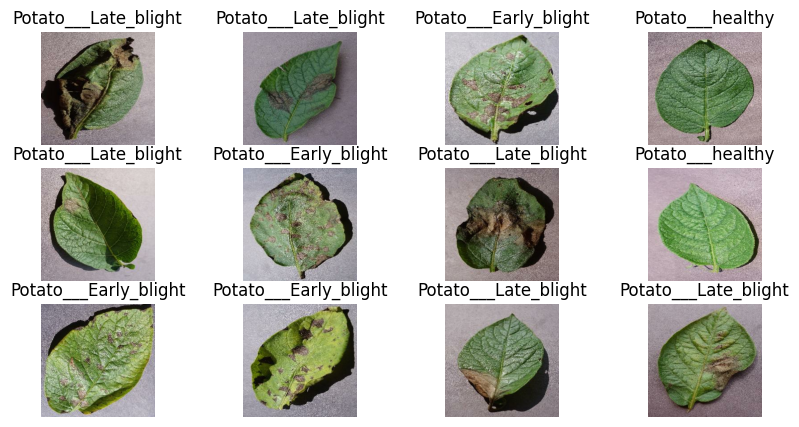

In [13]:
plt.figure(figsize=(10,5))
for img_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8')) # Converts the i-th image tensor to NumPy array and ensures it's in uint8 format (0–255 pixel values).
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

In [14]:
# 80% ==> Training
# 20% ==> test
#     10% ==> Validation
#     10% ==> Test

In [15]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1.0, "Splits must add up to 1.0"

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [17]:
len(train_ds) , len(val_ds), len(test_ds)

(54, 6, 8)

### 📚 TensorFlow Dataset Pipeline Operations

| 🛠️ Operation | 💡 Purpose | 📝 Details |
|--------------|------------|------------|
| 🧠 `cache()` | Speeds up data loading | - Stores the dataset in memory after the 1st epoch.<br>- Avoids repeated disk reads during training.<br>- Best used when the dataset fits in memory. |
| 🔀 `shuffle(1000)` | Randomizes data order | - Prevents the model from learning the order of the data.<br>- `1000` is the buffer size: it holds 1000 elements and samples randomly.<br>- Crucial for training data; optional for validation/test to preserve order. |
| 🚀 `prefetch(buffer_size=tf.data.AUTOTUNE)` | Improves pipeline efficiency | - Overlaps data preprocessing and model execution.<br>- `AUTOTUNE` lets TensorFlow choose the optimal buffer size automatically.<br>- Helps keep the GPU/CPU fed with data without waiting. |


In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
from keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

# Why Use a Sequential Model Here?

# Using tf.keras.Sequential for preprocessing layers allows you to:
    # Apply this transformation as part of your model pipeline.
    # Keep your code modular and clean.
    # Optionally include this preprocessing in the model itself, so it works even when deployed.

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

# You should apply data_augmentation only to the training dataset, not to validation or test data.
# It’s typically added as the first layer in your model or applied directly to the training pipeline.

In [21]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),  # Helps prevent overfitting
    layers.Dense(3, activation='softmax')  # 3 classes
    ])

model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.4535 - loss: 0.9757 - val_accuracy: 0.4635 - val_loss: 0.9410
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.5134 - loss: 0.9143 - val_accuracy: 0.4948 - val_loss: 0.9204
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.5372 - loss: 0.8553 - val_accuracy: 0.6615 - val_loss: 0.6205
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7572 - loss: 0.5401 - val_accuracy: 0.7917 - val_loss: 0.4583
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8026 - loss: 0.4432 - val_accuracy: 0.8594 - val_loss: 0.2907
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8525 - loss: 0.3472 - val_accuracy: 0.7760 - val_loss: 0.4346
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8955 - loss: 0.2775 - val_accuracy: 0.6823 - val_loss: 0.9254
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8550 - loss: 0.3185 - val_accuracy: 0.8906 -

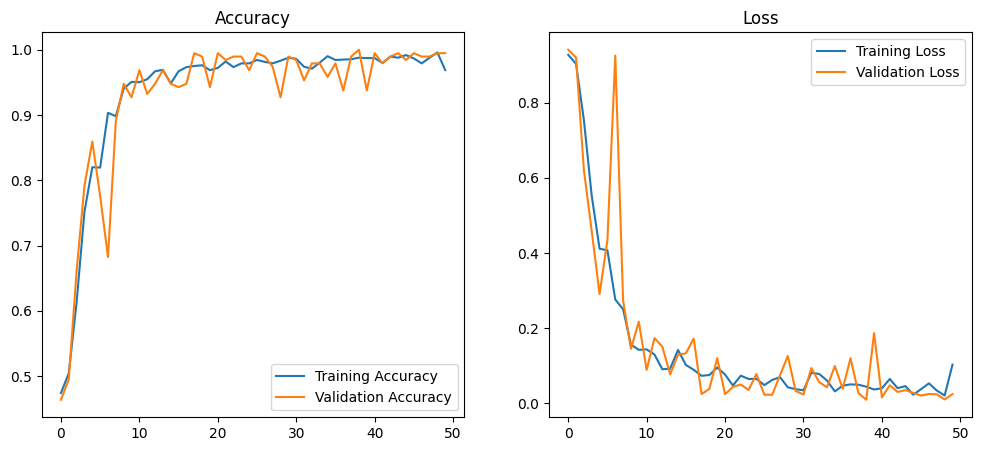

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [28]:
len(test_ds)

8

In [27]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9758 - loss: 0.0467


[0.03584575653076172, 0.98046875]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediction :  Potato___Late_blight


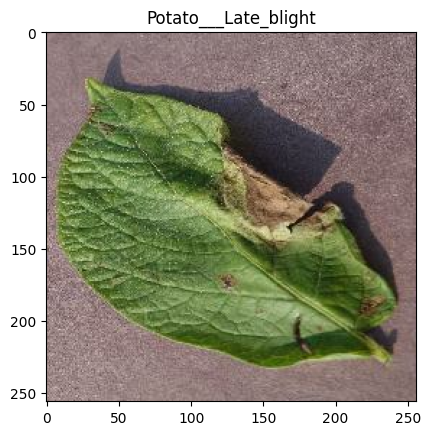

In [46]:
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  plt.title(class_names[labels_batch[0]])
  plt.imshow(first_image)

  batch_prediction = model.predict(images_batch)
  print("Prediction : ",class_names[batch_prediction[0].argmax()])

In [49]:
# function for inference
def predict(model, img):
    # Convert the input image tensor to float and normalize
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


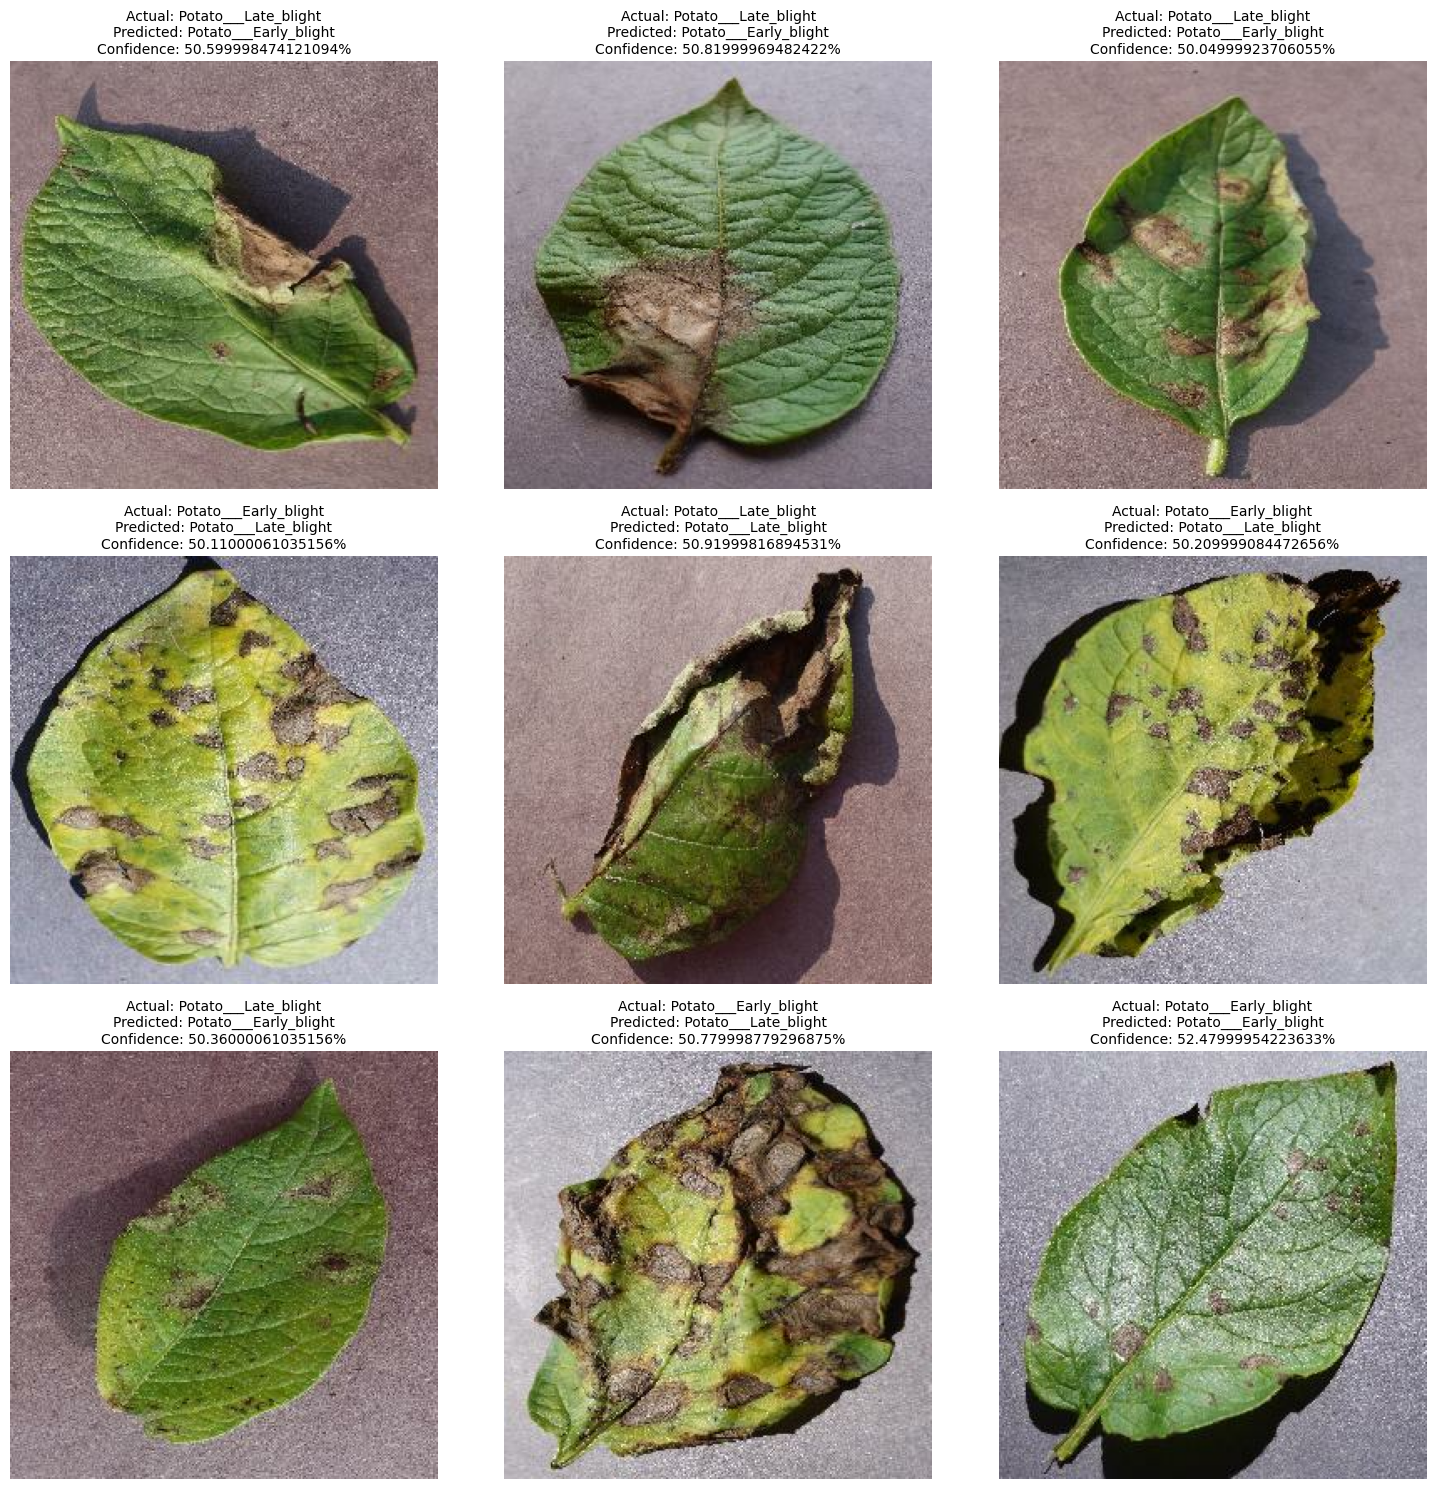

In [52]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):  # Take one batch from the test dataset
    for i in range(9):  # Show 9 images
        ax = plt.subplot(3, 3, i + 1)

        # Convert image to uint8 for display
        plt.imshow(images[i].numpy().astype("uint8"))

        # Run inference
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        # Set title with actual and predicted class
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%", fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()

In [57]:
model_version = 1
save_path = f"./models/{model_version}"

# Export the model in SavedModel format
model.export(save_path)

Saved artifact at './models/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137012792225296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137012749173200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137012749173776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137012749174160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137012749176848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137012749177424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137012749179920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137012749180304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137012749177232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137012749181072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137012749180496: Ten